In [1]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

from torch.utils.tensorboard import SummaryWriter


In [2]:
#import dataset
df = pd.read_csv('dataset-ml-25m/dataset.csv')

### Data Prepocessing

In [3]:
#split data and labels 
X = df.drop(['rating'], axis=1)
y = df['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#count the numebr of x_train 
print("Number of train set: ", X_train.shape[0])
print("Numebr of test set: ", X_test.shape[0])

Number of train set:  10362
Numebr of test set:  3454


In [4]:
#PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [5]:
# T-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=500)
X_train_tsne = tsne.fit_transform(X_train)


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


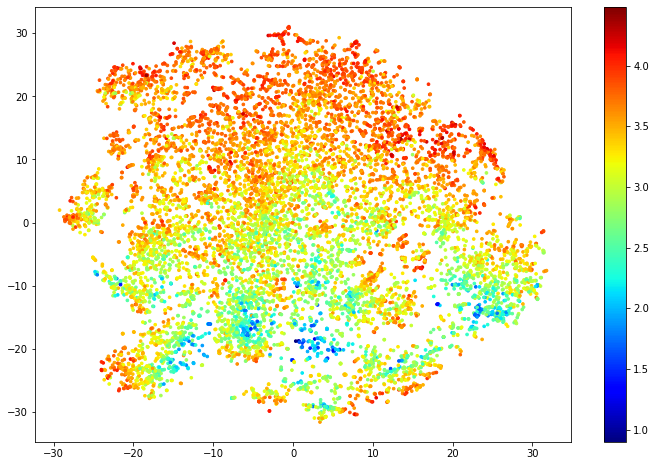

In [6]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="jet", s=7)
plt.colorbar()

plt.show()

### Linear Regressor

In [11]:
log_name = f"linear_regression"
writer = SummaryWriter(f"results/tradML/pca/LinearRegression/{log_name}")

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
y_pred = lin_regr.predict(X_test)

# Compute the RSS
mse = mean_squared_error(y_test, y_pred) 
print('Mean Square Error:', mse)
writer.add_scalar('Loss', mse)
writer.flush()

# Compute the R-square index
rsquare = r2_score(y_test, y_pred) 
print('R-square:', rsquare)


Mean Square Error: 0.006423379542790391
R-square: 0.9712582682254611


### Random Forest Regressor
TEST SET
Mean Squared Error:  0.03662117019915541

R2 Score:  0.8361367494911226

iper con pca = 30 e quared_error
91 min


In [69]:
param_grid = {
                "n_estimators": [10, 15, 20, 25, 30],
                "criterion": ["squared_error", "friedman_mse"]
              }
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
best_no_leaves= grid_search.best_params_
print("Best number of leaves: ", best_no_leaves)


Best number of leaves:  {'criterion': 'squared_error', 'n_estimators': 30}


In [72]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/RandomForestRegressor.csv")

{'mean_fit_time': array([24.61075759, 36.68426137, 49.03812804, 61.26886024, 73.39407592,
        25.22011824, 37.79118958, 50.43091807, 62.80687404, 75.51238852]),
 'std_fit_time': array([0.19939544, 0.24454192, 0.29303755, 0.32871682, 0.23015537,
        0.11294207, 0.20774709, 0.25172644, 0.35498514, 0.56024378]),
 'mean_score_time': array([0.01573792, 0.01407046, 0.01895251, 0.02211108, 0.02548656,
        0.01190801, 0.01491122, 0.01751604, 0.0212656 , 0.02551169]),
 'std_score_time': array([0.00531918, 0.00051303, 0.00297208, 0.00212369, 0.00253175,
        0.00058922, 0.00157414, 0.00111296, 0.00096347, 0.00164137]),
 'param_criterion': masked_array(data=['squared_error', 'squared_error', 'squared_error',
                    'squared_error', 'squared_error', 'friedman_mse',
                    'friedman_mse', 'friedman_mse', 'friedman_mse',
                    'friedman_mse'],
              mask=[False, False, False, False, False, False, False, False,
                    False, 

In [73]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_estimators', 'param_criterion', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/RandomForest/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_estimators = row['param_n_estimators']
    criterion = row['param_criterion']
    writer.add_hparams({"n_estimators": n_estimators, "criterion": criterion},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [74]:
rf = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
rf = rf.T
rf.to_csv('best_params/pca/random_forest.csv', index=False)

In [75]:
rf = RandomForestRegressor(n_estimators = 30, criterion = "squared_error")
rf= rf.fit(X_train,y_train)

y_pred= rf.predict(X_test)
print ("TEST SET")
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


TEST SET
Mean Squared Error:  0.037127476895492305
R2 Score:  0.8338712549543563


### Ridge Regressor
Mean Squared Error:  0.006422342939029505

R2 Score:  0.9712629065606324

In [12]:
param_grid = {
                "alpha":[0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20]
              }
ridge = Ridge()
ridge.fit(X_train,y_train)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best number of leaves: ", best_hyper)


Best number of leaves:  {'alpha': 5}


In [ ]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/Ridge.csv")

In [13]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/Ridge")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"/hparam/mse": mse})
    writer.flush()
writer.close()

In [14]:
ridge = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
ridge = ridge.T
ridge.to_csv('best_params/pca/ridge.csv', index=False)

In [ ]:
#plot mse vs alpha and put the red dot on the best alpha in base log scale and scale y in o.0001
plt.figure(figsize=(12, 8))
plt.plot(results['param_alpha'], results['mean_test_score'])
plt.scatter(best_hyper['alpha'], -1*grid_search.best_score_, c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('MSE vs alpha')
plt.show()

In [15]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

print("TEST SET")
y_pred= ridge.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


TEST SET
Mean Squared Error:  0.006422342939029505
R2 Score:  0.9712629065606324


### KNN Regressor
Mean Squared Error:  0.04392172471123978

R2 Score:  0.8034700546159548

In [58]:
param_grid = {
                'n_neighbors': [3, 4, 5, 7, 8, 9, 10],
                'weights': ['uniform', 'distance']
              }
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best number of leaves: ", best_hyper)

Best number of leaves:  {'n_neighbors': 10, 'weights': 'distance'}


In [60]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/KNN.csv")

{'mean_fit_time': array([0.0134737 , 0.01218996, 0.01225066, 0.01302919, 0.01237512,
        0.01177912, 0.0127995 , 0.01253381, 0.01247592, 0.01206779,
        0.01270294, 0.01239324, 0.0127502 , 0.01199775]),
 'std_fit_time': array([0.00275412, 0.00074924, 0.00083133, 0.00195359, 0.0004323 ,
        0.00021906, 0.00065931, 0.00052914, 0.00052339, 0.00053269,
        0.00064275, 0.00117668, 0.00043513, 0.00074373]),
 'mean_score_time': array([0.45207758, 0.42228394, 0.48188133, 0.49502177, 0.49198184,
        0.49274316, 0.48795991, 0.4913517 , 0.49522982, 0.49356298,
        0.48937364, 0.58957977, 0.597118  , 0.52691293]),
 'std_score_time': array([0.03899954, 0.00881771, 0.00369293, 0.00748125, 0.00678448,
        0.00902203, 0.00482453, 0.00459579, 0.00643667, 0.00920287,
        0.00319839, 0.07348981, 0.07902778, 0.02849202]),
 'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5, 7, 7, 8, 8, 9, 9, 10, 10],
              mask=[False, False, False, False, False, False, False,

In [59]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_neighbors', 'param_weights', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/KNN/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_neighbors = row['param_n_neighbors']
    weights = row['param_weights']
    writer.add_hparams({"n_neighbors": n_neighbors, "weights":weights},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [61]:
knn = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
knn = knn.T
knn.to_csv('best_params/pca/knn.csv', index=False)

In [62]:
knn = KNeighborsRegressor(n_neighbors= 10, weights= 'distance')
knn.fit(X_train, y_train)

print("TEST SET")
y_pred= knn.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.03994226940768822
R2 Score:  0.8212763256266444


### Lasso Regressor

Mean Squared Error:  0.006402684362671739

R2 Score:  0.971350869839928

In [32]:
param_grid = {
                'alpha':[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
              }
lasso = Lasso()
lasso.fit(X_train,y_train)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best values - Hyperparameters: ", best_hyper)

Best values - Hyperparameters:  {'alpha': 1e-05}


In [33]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/Lasso.csv")

{'mean_fit_time': array([0.07925024, 0.07515659, 0.07330732, 0.07482357, 0.08036418,
        0.0820827 ]),
 'std_fit_time': array([0.00948212, 0.00404517, 0.00155387, 0.00189503, 0.00100218,
        0.00121614]),
 'mean_score_time': array([0.00176954, 0.00180731, 0.00181742, 0.00166821, 0.00172052,
        0.0017045 ]),
 'std_score_time': array([1.57733451e-04, 1.57518058e-04, 1.69050132e-04, 4.16459321e-05,
        1.07864802e-04, 4.94009740e-05]),
 'param_alpha': masked_array(data=[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1},
  {'alpha': 0.01},
  {'alpha': 0.001},
  {'alpha': 0.0001},
  {'alpha': 1e-05},
  {'alpha': 1e-06}],
 'split0_test_score': array([-0.10544989, -0.03866443, -0.01145538, -0.00679534, -0.0062519 ,
        -0.00625076]),
 'split1_test_score': array([-0.09761941, -0.0374916 , -0.0110265 , -0.00659584, -0.00626647,
        -0.0062

In [34]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/Lasso/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [35]:
lasso = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
lasso= lasso.T
lasso.to_csv('best_params/pca/lasso.csv', index=False)

In [36]:
lasso = Lasso(alpha = 1e-05)
lasso.fit(X_train, y_train)

print("TEST SET")
y_pred= lasso.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.006402684362671749
R2 Score:  0.971350869839928


### SVR

Mean Squared Error:  0.0064680272514056085

R2 Score:  0.9710584898289305

51m

In [64]:
param_grid = {
                'kernel': ['linear', 'poly', 'rbf'],
                'epsilon': [0.001, 0.01, 0.1, 1]
              }
svr = SVR()
svr.fit(X_train,y_train)
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper = grid_search.best_params_
print("Best values - Hyperparameters: ", best_hyper)

Best values - Hyperparameters:  {'epsilon': 0.01, 'kernel': 'linear'}


In [65]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/pca/SVR.csv")

In [66]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_kernel','param_epsilon' ,'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1


#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/pca/SVR/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    kernel = row['param_kernel']
    epsilon = row['param_epsilon']
    writer.add_hparams({"kernel": kernel, "epsilon":epsilon},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [67]:
svr = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
svr = svr.T
svr.to_csv('best_params/pca/svr.csv', index=False)

In [68]:
svr = SVR(kernel ='linear', epsilon = 0.01)
svr.fit(X_train, y_train)

print("TEST SET")
y_pred= svr.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.0064680272514056085
R2 Score:  0.9710584898289305
